# Bank Marketing Data - A Multilayer Perceptron (MLP) Approach

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

https://medium.com/@nutanbhogendrasharma/deal-banking-marketing-campaign-dataset-with-machine-learning-9c1f84ad285d

### Install and Load Libraries

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 31.3 MB/s 
     |████████████████████████████████| 181 kB 66.1 MB/s 
     |████████████████████████████████| 147 kB 59.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d9a0371cd86fdc3f9c00ca7b46fdc17a043bb796852644bfbfc60dbba6a7f12e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [31]:
# Imports
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import os

# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import cross_val_score
# imblearn

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 1.0 Training



## 1.0.2 Holdout Configuration

In [32]:
# global variables

# ratio used to split train and validation data
val_size = 0.30
# seed used to reproduce purposes
seed = 41
# reference (column) to stratify the data
stratify = "y"
# name of the input artifact
artifact_input_name = "mlops_ivan/bank_mlp/train.csv:latest"
# type of the artifact
artifact_type = "Train"

In [33]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)


19-07-2022 17:09:55 Downloading and reading train artifact


In [58]:
# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")

# split-out train/validation dataset
train, val = train_test_split(  df_train,
                                test_size=val_size,
                                random_state=seed,
                                shuffle=True
                                )

19-07-2022 17:14:20 Spliting data into train/val


In [ ]:
logger.info("train: {}".format(train.shape))
logger.info("val: {}".format(val.shape))

18-07-2022 21:47:56 train: (22152, 17)
18-07-2022 21:47:56 val: (9495, 17)


## 1.1 Data preparation

### 1.1.1 Outlier Removal

In [59]:
logger.info("Outlier Removal")
# temporary variable
x = train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

19-07-2022 17:14:28 Outlier Removal


In [60]:
logger.info("train shape [original]: {}".format(train.shape))
logger.info("train shape [outlier removal]: {}".format(train.loc[mask,:].shape))

19-07-2022 17:14:30 train shape [original]: (22152, 17)
19-07-2022 17:14:30 train shape [outlier removal]: (21634, 17)


In [61]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
train = train.loc[mask,:].copy()

### 1.1.2 Balancing Data

Reference:
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [62]:
train.y.value_counts()

no     19250
yes     2384
Name: y, dtype: int64

In [63]:
# Return dataframe balanced: oversample and undersample
def resaple_bal(df, seed): 
  
  x_train = df.loc[:, df.columns != 'y']
  y_train = df.loc[:, df.columns == 'y']  
  oversample = SMOTENC(categorical_features=[1, 2, 3, 4, 6, 7, 8, 10, 15],  sampling_strategy = 0.7, random_state=seed) # 0.4
  undersample = RandomUnderSampler(sampling_strategy=0.7, random_state=seed)
  x_train, y_train = oversample.fit_resample(x_train, y_train)
  # x_train, y_train = undersample.fit_resample(x_train, y_train)
  df_o = pd.concat([x_train, y_train], axis=1)
  df_o = df_o.sample(frac=1, random_state=seed).reset_index(drop=True)
  return df_o


In [64]:
logger.info("Balance data")
train = resaple_bal( train, seed)

19-07-2022 17:14:35 Balance data


In [ ]:
# for validation purposes
# train.loc[0:10, 'y']

In [65]:
# for validation purposes
train.y.value_counts()

no     19250
yes    13475
Name: y, dtype: int64

### 1.1.3 Encoding Target Variable

In [66]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
train.loc[:, 'y'] = le.fit_transform(train.loc[:, 'y'])

# transform y_test (avoiding data leakage)
val.loc[:, 'y'] = le.transform(val.loc[:, 'y'])

val = val.reset_index(drop=True)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

19-07-2022 17:14:40 Encoding Target Variable
19-07-2022 17:14:40 Classes [0, 1]: ['no' 'yes']


### 1.1.4 Data split-out features and label

In [67]:
x_train = train.loc[:, train.columns != 'y']
y_train = train.loc[:, train.columns == 'y']  
x_val = val.loc[:, val.columns != 'y']
y_val = val.loc[:, val.columns == 'y']  

## 1.2 Data full-pipeline

### 1.2.1 Feature Extractor

In [43]:
def copy_exception(feature_names, exceptions):
  # this functios return the itens in the feature_names except exceptions
  # if exceptions do not exist in feature_names it returns all feature_names
  # Imput: feature_names, exceptions: list
  # Output: list
  for exception in exceptions:
    try:
      feature_names.remove(exception)
    except ValueError:
      pass
    features_selected = feature_names
  return features_selected

In [ ]:
f_sel = copy_exception(x_train.select_dtypes("object").columns.to_list(), ["contact", "day"])
print(f_sel)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'poutcome']


In [44]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
      #exceptions = ["contact", "day", 'default', 'loan', 'marital']
      #exceptions = ['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact', 'pdays', 'poutcome']
      #self.feature_names = copy_exception(feature_names, exceptions) 
      self.feature_names = feature_names


    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        #if self.new_features:
            # df['job'] = df['job']
            # Combine similar jobs into categiroes

            # df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            # df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            # df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            # df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # Drop 'contact', as every participant has been contacted. 
            # df.drop('contact', axis=1, inplace=True)

            # day  : last contact day of the month
            # month: last contact month of year
            # Drop 'month' as they don't have any intrinsic meaning
            # df.drop('month', axis=1, inplace=True)
            # df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            # df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            # df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            # df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')         

        # update column names
        self.colnames = df.columns

        return df
        
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # day  : last contact day of the month                  # adicionado
        # Drop 'day' as they don't have any intrinsic meaning
        # df.drop('day', axis=1, inplace=True)

        # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
        # df.loc[df['pdays'] == -1, 'pdays'] = 10000

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,housing,contact,month,poutcome
0,technician,married,secondary,yes,cellular,may,success
1,entrepreneur,married,tertiary,yes,cellular,may,failure
2,blue-collar,married,primary,yes,cellular,feb,other
3,admin.,single,tertiary,yes,cellular,apr,unknown
4,blue-collar,married,secondary,yes,cellular,may,failure


In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,balance,day,duration,campaign,pdays,previous
0,31,146,14,206,2,410,1
1,49,4976,13,36,9,173,1
2,35,0,2,698,2,271,2
3,34,18,30,359,1,-1,0
4,33,327,16,946,1,343,1


### 1.2.2 Handling Categorical Features

In [ ]:
x_train.month.unique()

array(['may', 'feb', 'apr', 'aug', 'jul', 'nov', 'jun', 'sep', 'oct',
       'dec', 'jan', 'mar'], dtype=object)

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,housing,contact,month,poutcome
0,technician,married,secondary,yes,cellular,2st,success
1,entrepreneur,married,tertiary,yes,cellular,2st,failure
2,blue-collar,married,primary,yes,cellular,1st,unknown
3,white-collar,single,tertiary,yes,cellular,2st,unknown
4,blue-collar,married,secondary,yes,cellular,2st,failure


In [ ]:
# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [ ]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job          7
marital      3
education    4
housing      2
contact      3
month        4
poutcome     3
dtype: int64

### 1.2.3 Handling Numerical Features

In [ ]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[ -0.92691617,  -0.4615213 ,  -0.18731613, ...,  -0.17766292,
          3.7155654 ,   0.19998433],
       [  0.76432627,   1.25083461,  -0.31358469, ...,   2.3991367 ,
          1.3106768 ,   0.19998433],
       [ -0.55108452,  -0.51328195,  -1.70253883, ...,  -0.17766292,
          2.30510331,   0.74940163],
       ...,
       [ -0.64504243,   0.11989976,  -1.07119604, ...,  -0.54577716,
        101.02730213,  -0.34943297],
       [ -0.36316869,  -0.55263423,  -0.31358469, ...,   0.55856554,
        101.02730213,  -0.34943297],
       [  0.85828419,  -0.5040643 ,   1.07536946, ...,   0.55856554,
        101.02730213,  -0.34943297]])

In [ ]:
# for validation purposes
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### 1.2.4 Data Preparation Pipeline

In [45]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 2

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list() 

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="if_binary"))
                                       ]
                                ) # drop="first"

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipe = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [46]:
x_train_encoded = full_pipe.fit_transform(x_train)
x_val_encoded = full_pipe.transform(x_val)

# Transform the data
# cat_names is a numpy array
cat_names = full_pipe.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipe.get_params()["num_pipeline"][2].get_feature_names_out()
# Transform the data
x_train_encoded = pd.DataFrame(x_train_encoded,columns = cat_names + num_names)
x_val_encoded = pd.DataFrame(x_val_encoded ,columns = cat_names + num_names)

In [47]:
train_encoded = pd.concat([x_train_encoded, y_train], axis=1)
val_encoded = pd.concat([x_val_encoded, y_val], axis=1)

In [ ]:
# for validation purposes
train_encoded #.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,34.0,7478.0,30.0,345.0,1.0,-1.0,0.0,1
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,32.0,1954.0,10.0,107.0,1.0,-1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,28.0,2788.0,6.0,369.0,2.0,-1.0,0.0,1
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,57.0,350.0,4.0,87.0,3.0,-1.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,32.0,1493.0,28.0,65.0,11.0,-1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,51.0,-437.0,30.0,130.0,3.0,-1.0,0.0,0
32721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,26.0,620.0,22.0,223.0,1.0,94.0,1.0,1
32722,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,43.0,1809.0,6.0,312.0,1.0,-1.0,0.0,1
32723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,37.0,-111.0,13.0,147.0,4.0,-1.0,0.0,0


In [ ]:
val_encoded

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,27.0,1.0,2.0,261.0,8.0,-1.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,49.0,23.0,23.0,247.0,1.0,-1.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,33.0,1278.0,6.0,649.0,1.0,-1.0,0.0,1
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,59.0,266.0,30.0,147.0,2.0,-1.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,38.0,-3.0,20.0,251.0,2.0,101.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9490,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,31.0,1306.0,28.0,217.0,5.0,-1.0,0.0,0
9491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,43.0,463.0,3.0,268.0,1.0,-1.0,0.0,0
9492,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,28.0,708.0,6.0,339.0,5.0,-1.0,0.0,0
9493,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,27.0,220.0,19.0,480.0,1.0,-1.0,0.0,0


In [ ]:
# saving transformed train data to csv
train_encoded.to_csv("aencoded_train_data.csv", index=False)
val_encoded.to_csv("aencoded_val_data.csv", index=False)

#run = wandb.init(project="bank_mlp", entity="mlops_ivan", job_type="encode_data")

In [ ]:
# Uploading Transformed Data
# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name="encoded_train_data.csv",
                          type="encoded_data",
                          description="Upload encoded Train Data")

artifact.add_file("encoded_train_data.csv")
run.log_artifact(artifact)

# Uploading Transformed Data
# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name="encoded_val_data.csv",
                          type="encoded_data",
                          description="Upload encoded Val Data")

artifact.add_file("encoded_val_data.csv")
run.log_artifact(artifact)

In [ ]:
run.finish()

os.remove('encoded_train_data.csv')
os.remove('encoded_val_data.csv')

## 1.6 Hyperparameter Tuning

## 4.1 Monitoring a neural network

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 147 kB 63.4 MB/s 
     |████████████████████████████████| 181 kB 45.3 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=68d324eda5597b458d2cb76b9f793934c0dd731969425f816d40cfd90cd3064b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [3]:
import wandb
import logging
from wandb.keras import WandbCallback
import pandas as pd
import numpy as np
import os

from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.metrics import geometric_mean_score

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential
from keras import callbacks
# from keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

from keras.constraints import max_norm
import matplotlib.pyplot as plt

In [ ]:
# os.environ['WANDB_NOTEBOOK_NAME'] = 'train_test.ipynb'

In [4]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

Better Genaralization

1. Regularization L2 ok
2. Penalize large weights 
3. weight constraint
4. Dropout ok
5. Noise ok (oversample)
6. Early stoping ok

In [73]:
# Default values for hyperparameters
defaults = dict(layer_1 = 40,
                layer_2 = 80,
                learn_rate = 0.1,
                batch_size = 512,
                epoch = 500,
                dropout1 = 0.8,
                dropout2 = 0.6,
                l2_1 = 0.0001,
                l2_2 = 0.0001,
                gradient_cliping = 1,
                bath_norm = 1
                )

# Default values for hyperparameters
defaults = dict(layer_1 = 16,
                layer_2 = 44,
                learn_rate = 0.1,
                batch_size = 4096,
                epoch = 500,
                dropout1 = 1,
                dropout2 = 1,
                l2_1 = 0.0,
                l2_2 = 0.0,
                gradient_cliping = 1,
                bath_norm = 1
                )

fmonitor =  "val_f1_score" #  "val_binary_accuracy" # "val_f1_score"

# Default values for hyperparameters
# defaults = dict(layer_1 = 32,
#                 layer_2 = 32,
#                 learn_rate = 0.01,
#                 batch_size = 4096,
#                 epoch = 500,
#                 dropout1 = 1.0,
#                 dropout2 = 1.0,
#                 l2_1 = 0.0,
#                 l2_2 = 0.0,
#                 gradient_cliping = 0,
#                 bath_norm = 1
#                 )

# https://medium.com/@nutanbhogendrasharma/deal-banking-marketing-campaign-dataset-with-machine-learning-9c1f84ad285d

In [74]:
wandb.config=defaults

In [8]:
run = wandb.init(project="bank_mlp", entity="mlops_ivan", config= defaults, name="run_01")
config = wandb.config

wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


In [12]:
# Downloading and reading encoded train val artifact
logger.info("Downloading and reading encoded train artifact")
local_path = run.use_artifact("encoded_train_data.csv:latest").file()
train_encoded = pd.read_csv(local_path)

logger.info("Downloading and reading encoded val artifact")
local_path = run.use_artifact("encoded_val_data.csv:latest").file()
val_encoded = pd.read_csv(local_path)

x_train_encoded = train_encoded.loc[:, train_encoded.columns != 'y']
y_train = train_encoded.loc[:, train_encoded.columns == 'y']  
x_val_encoded = val_encoded.loc[:, val_encoded.columns != 'y']
y_val = val_encoded.loc[:, val_encoded.columns == 'y'] 

19-07-2022 16:56:03 Downloading and reading encoded train artifact
19-07-2022 16:56:04 Downloading and reading encoded val artifact


In [13]:
train_encoded.y.value_counts()

0    19250
1    13475
Name: y, dtype: int64

In [75]:
# Instantiate a simple classification model
model = tf.keras.Sequential()
if config.l2_1!=0.0:
  model.add(layers.Dense( config.layer_1,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_1),
                dtype='float64'))
else:
  model.add(layers.Dense( config.layer_1,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                dtype='float64'))
if config.bath_norm==1.0:
  model.add(layers.BatchNormalization())
if config.dropout1!=1.0:
  model.add(layers.Dropout(config.dropout1))
if config.l2_2!=0.0:
  model.add(layers.Dense( config.layer_2,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_2),
                dtype='float64'))
else:
  model.add(layers.Dense( config.layer_2,
                activation=tf.nn.relu,
                kernel_initializer='he_uniform',
                dtype='float64'))
if config.bath_norm==1:
  model.add(layers.BatchNormalization())
if config.dropout2!=1.0:
  model.add(layers.Dropout(config.dropout2))
model.add(layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))

# model = tf.keras.Sequential([
#   #layers.Dropout(0.5),
#   layers.Dense( config.layer_1,
#                 activation=tf.nn.relu,
#                 kernel_initializer='he_uniform',
#                 #kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_1),
#                 dtype='float64'),
#   layers.Dropout(config.dropout1),
#   layers.BatchNormalization(),
#   layers.Dense( config.layer_2,
#                 activation=tf.nn.relu,
#                 kernel_initializer='he_uniform',
#                 #kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_2),
#                 dtype='float64'),  
#   layers.Dropout(config.dropout2),
#   layers.BatchNormalization(),
#   layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64')
# ])

# Instantiate a logistic loss function that expects integer targets.
loss = tf.keras.losses.BinaryCrossentropy()

# Instantiate an accuracy metric.
# metric = tf.keras.metrics.BinaryAccuracy()
# metric = tf.keras.metrics.BinaryAccuracy()
m_f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
m_bacc_score = tf.keras.metrics.BinaryAccuracy()

# Instantiate an optimizer.
if config.gradient_cliping==0.0:
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learn_rate)
else:
    optimizer = tf.keras.optimizers.Adam( 
                                    learning_rate=config.learn_rate,
                                    clipvalue= config.gradient_cliping
                                    )


# configure the optimizer, loss, and metrics to monitor.
model.compile(optimizer=optimizer, loss=loss, metrics=[m_f1_score, m_bacc_score ])

In [76]:
early_stopping = callbacks.EarlyStopping(
                monitor=fmonitor,   # 'loss'  "val_loss"           
                min_delta=0.001, # Minimum change
                patience=100, # Number of epochs with no improvement
                verbose=1, # 
                mode='max', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

In [77]:
# %%wandb
# Add WandbCallback() to the fit function
hist = model.fit(x= x_train_encoded , # full_pipe.transform(x_train)
          y= y_train,
          batch_size=config.batch_size,
          epochs=config.epoch,
          validation_data=( x_val_encoded, y_val), # full_pipe.transform(x_val_bal)
          callbacks=[
                    WandbCallback(monitor=fmonitor,
                                  mode="max",
                                  training_data=(x_train_encoded, y_train),
                                  validation_data=(x_val_encoded, y_val),
                                  save_model="True",
                                  log_weights=True),
                                  early_stopping],
                                  verbose=1)

# predict
y_pred = np.rint(model.predict(x_val_encoded)).ravel()

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val.values.ravel(), y_pred, beta=1, zero_division=1)
precision = precision_score(y_val.values.ravel(), y_pred, zero_division=1)
recall = recall_score(y_val.values.ravel(), y_pred, zero_division=1)
acc = accuracy_score(y_val.values.ravel(), y_pred)
g_mean = geometric_mean_score(y_val.values.ravel(), y_pred)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("G-Mean: {}".format(g_mean))

run.summary["Accuracy"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
run.summary["G-Mean"] = g_mean  

wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/500
8/8 [==============================] - 1s 60ms/step - loss: 0.6004 - f1_score: 0.5784 - binary_accuracy: 0.6690 - val_loss: 11.0389 - val_f1_score: 0.2204 - val_binary_accuracy: 0.1425 - _timestamp: 1658252330.0000 - _runtime: 1643.0000
Epoch 2/500
8/8 [==============================] - 0s 27ms/step - loss: 0.4949 - f1_score: 0.6964 - binary_accuracy: 0.7581 - val_loss: 4.7849 - val_f1_score: 0.2305 - val_binary_accuracy: 0.2298 - _timestamp: 1658252330.0000 - _runtime: 1643.0000
Epoch 3/500
8/8 [==============================] - 0s 27ms/step - loss: 0.4840 - f1_score: 0.7092 - binary_accuracy: 0.7690 - val_loss: 3.0398 - val_f1_score: 0.2408 - val_binary_accuracy: 0.2707 - _timestamp: 1658252330.0000 - _runtime: 1643.0000
Epoch 4/500
8/8 [==============================] - 0s 25ms/step - loss: 0.4701 - f1_score: 0.7156 - binary_accuracy: 0.7697 - val_loss: 1.1742 - val_f1_score: 0.3111 - val_binary_accuracy: 0.5220 - _timestamp: 1658252331.0000 - _runtime: 1644.0000
Epoch 5

19-07-2022 17:39:34 Evaluation metrics
19-07-2022 17:39:34 Accuracy: 0.8888888888888888
19-07-2022 17:39:34 Precision: 0.5351390922401171
19-07-2022 17:39:34 Recall: 0.6350999131190269
19-07-2022 17:39:34 F1: 0.5808502185141041
19-07-2022 17:39:34 G-Mean: 0.7660072882526051


In [78]:
evalu = model.evaluate(x_val_encoded,y_val)

297/297 [==============================] - 0s 1ms/step - loss: 0.2813 - f1_score: 0.5809 - binary_accuracy: 0.8889


In [18]:
model.summary() # mostra modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                528       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 44)                748       
                                                                 
 batch_normalization_1 (Batc  (None, 44)               176       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 45        
                                                                 
Total params: 1,561
Trainable params: 1,441
Non-trainabl

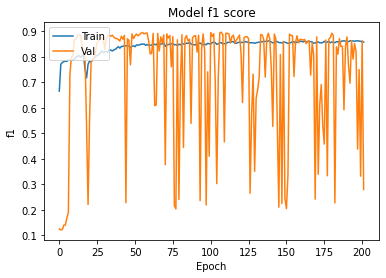

In [22]:
plt.plot(hist.history['binary_accuracy'])
plt.plot(hist.history['val_binary_accuracy'])
plt.title('Model f1 score')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend(['Train', 'Val'], loc = 'upper left')

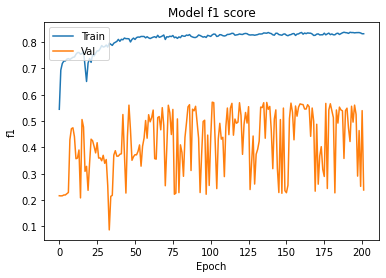

In [19]:
plt.plot(hist.history['f1_score'])
plt.plot(hist.history['val_f1_score'])
plt.title('Model f1 score')
plt.xlabel('Epoch')
plt.ylabel('f1')
plt.legend(['Train', 'Val'], loc = 'upper left')

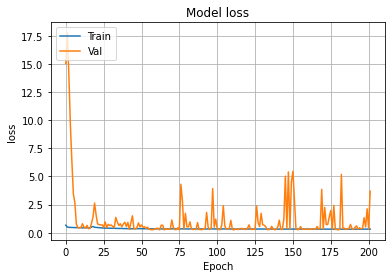

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
run.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███▇▇██████▇█████
loss,█▅▃▃▃▃▃▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▂▂▁▁▂
val_f1_score,▂▇▇▇▁▃▇▇▅▇▇▆█▅██▇▇█▇██▅▇█▅▇▇▅▄▄▂▇▇█▅█▇▇▇
val_loss,▇▂▁▁█▅▃▂▅▂▃▄▂▅▂▁▂▄▁▃▁▂▄▂▂▄▂▂▄▆▅▆▃▃▁▅▂▂▂▂
Accuracy,0.87709
F1,0.57237
G-Mean,0.78341
Precision,0.49493
Recall,0.67854
best_epoch,281


https://wandb.ai/mlops_ivan/bank_mlp/runs/15buqxk3

Epoch 132: early stopping
18-07-2022 12:46:04 Evaluation metrics
18-07-2022 12:46:04 Accuracy: 0.8646656134807793
18-07-2022 12:46:04 Precision: 0.46265328874024525
18-07-2022 12:46:04 Recall: 0.7211120764552563
18-07-2022 12:46:04 F1: 0.5636672325976231
18-07-2022 12:46:04 G-Mean: 0.7986241107722596
https://wandb.ai/mlops_ivan/bank_mlp/runs/16q023ea

## 4.2 Sweeps

In [ ]:
def train_func():

     # The sweep calls this function with each set of hyperparameters
    # Default values for hyperparameters
    defaults = dict(layer_1 = 32,
                layer_2 = 32,
                learn_rate = 0.001,
                batch_size = 512,
                epoch = 300,
                dropout1 = 0.9,
                dropout2 = 0.9,
                l2_1 = 0.0,
                l2_2 = 0.0,
                gradient_cliping = 2,
                bath_norm = 1)
    
    # Initialize a new wandb run
    wandb.init(project="bank_mlp_a", entity="mlops_ivan", config= defaults)
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Instantiate a simple classification model
# Instantiate a simple classification model
    # Instantiate a simple classification model
    model = tf.keras.Sequential()
    if config.l2_1!=0.0:
      model.add(layers.Dense( config.layer_1,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_1),
                    dtype='float64'))
    else:
      model.add(layers.Dense( config.layer_1,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    dtype='float64'))
    if config.bath_norm==1.0:
      model.add(layers.BatchNormalization())
    if config.dropout1!=1.0:
      model.add(layers.Dropout(config.dropout1))
    if config.l2_2!=0.0:
      model.add(layers.Dense( config.layer_2,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    kernel_regularizer = tf.keras.regularizers.L2(l=config.l2_2),
                    dtype='float64'))
    else:
      model.add(layers.Dense( config.layer_2,
                    activation=tf.nn.relu,
                    kernel_initializer='he_uniform',
                    dtype='float64'))
    if config.bath_norm==1:
      model.add(layers.BatchNormalization())
    if config.dropout2!=1.0:
      model.add(layers.Dropout(config.dropout2))
    model.add(layers.Dense(1, activation=tf.nn.sigmoid, dtype='float64'))
    
    
    # Instantiate a logistic loss function that expects integer targets.
    loss = tf.keras.losses.BinaryCrossentropy()

    # Instantiate an accuracy metric.
    # metric = tf.keras.metrics.BinaryAccuracy()
    m_f1_score = tfa.metrics.F1Score(num_classes=1, threshold=0.5)
    m_bacc_score = tf.keras.metrics.BinaryAccuracy()

    # Instantiate an optimizer.
    if config.gradient_cliping==0.0:
        optimizer = tf.keras.optimizers.Adam(learning_rate=config.learn_rate)
    else:
        optimizer = tf.keras.optimizers.Adam( 
                                        learning_rate=config.learn_rate,
                                        clipvalue= config.gradient_cliping
                                        )

    # configure the optimizer, loss, and metrics to monitor.
    model.compile(optimizer=optimizer, loss=loss, metrics=[m_f1_score, m_bacc_score ])

    # early_stopping = callbacks.EarlyStopping(
    #             monitor='val_loss',   # 'loss'             
    #             min_delta=0.001, # Minimum change
    #             patience=100, # Number of epochs with no improvement
    #             verbose=1, # 
    #             mode='auto', # "auto", "min", "max"
    #             baseline=None, # Baseline value for the monitored quantity
    #             restore_best_weights=True) # restore weights epoch with best value

    early_stopping = callbacks.EarlyStopping(
                monitor=fmonitor,   # 'loss'  "val_loss"           
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='max', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

    model.fit(x= x_train_encoded , # full_pipe.transform(x_train)
              y= y_train,
              batch_size=config.batch_size,
              epochs=config.epoch,
              validation_data=( x_val_encoded, y_val), # full_pipe.transform(x_val)
              callbacks=[
                          WandbCallback(monitor=fmonitor,
                                  mode="max",
                                  training_data=(x_train_encoded, y_train),
                                  validation_data=(x_val_encoded, y_val),
                                  save_model="True",
                                  log_weights=True),
                                  early_stopping],
                                  verbose=0)
                        #  WandbCallback( monitor="val_f1_score",
                        #                 mode="max",
                        #                 validation_data=(x_val_encoded, y_val),
                        #                 save_model="True",
                        #                 log_weights=True),
                        #                 early_stopping],
                        #                 verbose=0 )

    
    y_pred = np.rint(model.predict(x_val_encoded)).ravel()

    # Evaluation Metrics
    fbeta = fbeta_score(y_val.values.ravel(), y_pred, beta=1, zero_division=1)
    precision = precision_score(y_val.values.ravel(), y_pred, zero_division=1)
    recall = recall_score(y_val.values.ravel(), y_pred, zero_division=1)
    acc = accuracy_score(y_val.values.ravel(), y_pred)
    g_mean = geometric_mean_score(y_val.values.ravel(), y_pred)

    # run.summary["Accuracy"] = acc
    # run.summary["Precision"] = precision
    # run.summary["Recall"] = recall
    # run.summary["F1"] = fbeta
    # run.summary["G-Mean"] = g_mean  
    # 
    metrics = { "val_accuracy": acc,
                "val_precision": precision,
                "val_recall": recall,
                "val_F1": fbeta,
                "val_G-Mean": g_mean
                }
    wandb.log(metrics) 

In [ ]:
# See the source code in order to see other parameters
# https://github.com/wandb/client/tree/master/wandb/sweeps

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'binary_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'layer_1': {
            'max': 64,
            'min': 16,
            'distribution': 'int_uniform',
        },
        'layer_2': {
            'max': 64,
            'min': 16,
            'distribution': 'int_uniform',
        },
        'learn_rate': {
            'min': -3,
            'max': -2,
            'distribution': 'log_uniform', #  log_uniform
        },
        'batch_size': {
            'values': [256,1024,4096,8192]
        },
        'epoch': {
            'values': [500]
        },
        'dropout1': {
            'values': [0.5,0.7,0.9,1.0] 
        },
        'dropout2': {
            'values': [0.5,0.7,0.9,1.0] 
        },
        'l2_1': {
            'values': [0.01,0.001,0.0001,0.0]  
        },
        'l2_2': {
            'values': [0.01,0.001,0.0001,0.0]  
        },
        'gradient_cliping': {
            'values': [0.0,0.5,1.0]
        },
        'bath_norm': {
            'values': [0,1]
        }
    }
}

# sweep_config = {
#     'method': 'random', #grid, random
#     'metric': {
#       'name': 'binary_accuracy',
#       'goal': 'maximize'   
#     },
#     'parameters': {
#         'layer_1': {
#             'max': 48,
#             'min': 8,
#             'distribution': 'int_uniform',
#         },
#         'layer_2': {
#             'max': 48,
#             'min': 8,
#             'distribution': 'int_uniform',
#         },
#         'learn_rate': {
#             'min': -4,
#             'max': -2,
#             'distribution': 'log_uniform', #  log_uniform
#         },
#         'batch_size': {
#             'values': [32,128,256,1024,4096]
#         },
#         'epoch': {
#             'values': [200,300,500]
#         },
#         'dropout1': {
#             'min': 0.3,
#             'max': 0.99,
#             'distribution': 'uniform',  
#         },
#         'dropout2': {
#             'min': 0.3,
#             'max': 0.99,
#             'distribution': 'uniform',  
#         },
#         'l2_1': {
#             'min': 0.0,
#             'max': 0.01,
#             'distribution': 'uniform',  
#         },
#         'l2_2': {
#             'min': 0.0,
#             'max': 0.01,
#             'distribution': 'uniform',  
#         },
#         'gradient_cliping': {
#             'values': [0.0,0.5,1.0]
#         },
#         'bath_norm': {
#             'values': [0,1]
#         }
#     }
# }

In [ ]:
# Initialize a new sweep

sweep_id = wandb.sweep(sweep_config, entity="mlops_ivan", project="bank_mlp_a")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. learn_rate uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: xrz7oqqv
Sweep URL: https://wandb.ai/mlops_ivan/bank_mlp_a/sweeps/xrz7oqqv


In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id = sweep_id, function=train_func,count=80)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 8fc36x2k with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 53
wandb: 	layer_2: 30
wandb: 	learn_rate: 0.1208539189975652
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 64.
Epoch 114: early stopping


binary_accuracy,▁▅▇▇▇▇██████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▇▇▇▇███████████▇██████████████████████
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▆▆▅▆▅▄▃▁▆▅▇▇▅▅▇█▄▇▆▇█▅█▅▇▇▆▇███▇▇██▆▇▇▇▇
val_f1_score,▁▅▅▅▅▄▃▂▇▅▇█▅▅██▄▇▆▆▇▅█▄▇▇▅▇███▇███▆▇▇██
val_loss,█▃▃▂▃▃▃▄▂▃▂▂▃▃▂▁▃▂▂▂▁▂▁▃▂▂▂▂▁▁▁▂▁▁▁▂▂▂▁▂
val_precision,▁


wandb: Agent Starting Run: zzt7hiv0 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 26
wandb: 	layer_2: 16
wandb: 	learn_rate: 0.06803588557513278
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 15.
Epoch 65: early stopping


binary_accuracy,▁▆▇▇▄▆▆▆▆▅▅▅▅▂▅▃█▅▅▅▄▅▅▆▇▇▅█▆▃▄▄▆▄▅▂▄▇█▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▂▇██▅▇▇▇█▆▇▆▇▁▆▂█▅▆▇▅▅▆▆██▅█▇▄▄▄▆▃▄▁▄▇█▃
loss,█▃▂▂▅▃▂▂▂▂▄▄▂█▃█▃▇▂▃▄▃▄▃▁▁▃▂▁▅▇▅▄█▇█▆▄▃▇
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▇▇▇▆▆▇█▆█▇▁▇▇▇██▇▇▆▅▄▆██▇▇▆▆▇▃▇▆██▇▇▆█▇
val_f1_score,▁▆▇▅▆▆▅▇▅█▇▁▅█▇▇▆▆▅▅▄▃▅▆█▆▆▅▆▅▂▄▅▇▄▄▆▅▃▇
val_loss,█▂▂▁▃▂▁▃▃▃▃▄▂▃▃▂▁▃▁▃▄▄▄▁▁▁▂▃▃▂▄▂▃▃▂▃▂▄▂▂
val_precision,▁


wandb: Agent Starting Run: bqsrskx0 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 63
wandb: 	layer_2: 39
wandb: 	learn_rate: 0.08581478224577486
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 7.
Epoch 57: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁██████████████████████████████████▁████
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆▆▅▄▄▄▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▅█▅▄▃
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gbv2tql0 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 29
wandb: 	layer_2: 20
wandb: 	learn_rate: 0.06933432123415774
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 38.
Epoch 88: early stopping


binary_accuracy,▁▆▅▅▅▅▅▅▅▆▆▆▇█▇▆▆▇▇▆▆▆▆▆▆▇▇██▇▇▇▆▇▇▇▇▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▆▅▆▅▄▄▅▅▆▆▆█▆▆▅▇▆▆▅▅▅▆▆▇▇█▇▇▇▆▅▇▇▇▇▇█▇
loss,█▂▃▃▃▃▄▄▃▃▃▃▃▂▂▂▃▃▂▂▃▂▃▂▂▁▂▂▁▁▂▂▃▂▂▂▂▂▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▄▅▁▅▇▇▇▇▇▇▆▆▆▆▇▇▇▇███▇▇██▇▇▇▆█▃▇█▅█▇██▆▇
val_f1_score,▃▆▃▇▆█▃▆█▇█▇▆▇▇▇▄█▄▆▅▇▆▄▆█▆▆▇▅▄▇▁▅▄▇▆▂▇▇
val_loss,█▅█▇▅▄▆▄▄▄▅▅▄▄▄▄▂▅▃▄▄▄▃▃▃▅▃▄▄▁▇▄▁▇▂▃▂▄▄▃
val_precision,▁


wandb: Agent Starting Run: tc12w6o0 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 16
wandb: 	layer_2: 25
wandb: 	learn_rate: 0.05202165931654232
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 62.
Epoch 112: early stopping


binary_accuracy,▁▂▄▅▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇███████▇████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▂▅▆▇▇▇▇█▇▇▇▇▇▇█▇▇▇▇████████████████████
loss,█▆▄▃▂▂▂▂▁▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇█▁▂▃█▇▇██▂█▇██▅███▇▇█▂▄██▁▇█▇▇▇▇▆▇█▆██▇
val_f1_score,▆▄▁▂▂▇▇▆▇▅▂▇█▇▇▅▆▄▇▇▇█▂▃▇▇▂█▇▇▇██▅▇▇▅██▇
val_loss,▁▃▅▃▃▁▂▂▁▂▄▁▁▁▁▂▁▂▁▂▁▁▆▃▁▁█▁▁▁▂▁▁▂▂▁▂▁▁▂
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o3h9shmj with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 20
wandb: 	layer_2: 53
wandb: 	learn_rate: 0.11423253061309438
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


binary_accuracy,▁▅▆▆█▆▆▇▅▅▇▆▅▇▇▇▆▆▇▆▆▅▆▇▆█▇█▆▆█▆▆▆▇▆▇▇▆▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▂▄▆▄▃▄▃▃▄▅▂▅█▅▅▃▄▃▄▂▄▅▃▆▅▆▃▄▇▃▆▃▅▅▅▆▄▅
loss,▆▁▁▂▁▁▂▂▃▃▃▃▃▄▂▂▂▂▂▄▄▂▂▂▁▁▂▁▂▄▁▂▁▃▂▁▂▃█▄
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██▇███████████▁█████████████████████████
val_f1_score,▅▂█▁▇▃▁▂▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▆▁▂▁▁▂▂▂▁▁▂▄▂▂▁▁▁
val_loss,▁▁▅▄▄▄▃▂▃▆▅▄▂▅▇▄▃▃▃▄▂▂▂▃▃▄▂▃▆▄▅▃▃▃▆▃▂▅█▄
val_precision,▁


wandb: Agent Starting Run: uowrzmfn with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 54
wandb: 	layer_2: 25
wandb: 	learn_rate: 0.058676579016027616
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▃▁██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 8zbrk5k7 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 16
wandb: 	layer_2: 60
wandb: 	learn_rate: 0.05421736585858555
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 46.
Epoch 96: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: ducougab with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 49
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.08834367830158152
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 6.
Epoch 56: early stopping


binary_accuracy,▁▇▇████▇██▇█▇███████▇▇▇▇█▇█▇████████▇█▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▇▇█▇██▇█▇█████▇▇███▇▇▇▇▇▇█▇▇▇▇▇██▇█▇▇▇▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▇▇██▇█▇▇▇▇▆▇▇▅█▆▇███▆▆▇▆▇█▇▅▁█▇▇▇▇█▇██▇
val_f1_score,▅▇▇██▇█▇▇▇▇▅▇▇▄█▆▆▇██▅▅▇▅▆▇▇▄▁█▇▇▇▇█▆▇█▇
val_loss,█▃▂▁▁▃▁▂▂▂▁▄▃▂▅▂▄▄▁▂▁▄▄▂▅▂▁▂▆█▂▄▃▃▂▁▃▂▂▂
val_precision,▁


wandb: Agent Starting Run: 6xzg1ryu with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 29
wandb: 	layer_2: 58
wandb: 	learn_rate: 0.10963660568480307
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 89.
Epoch 139: early stopping


binary_accuracy,▅▃▅▃▄▅▃▅▅▁▆▅▅▆▆▆█▁▃▆▆▃▆▇▃█▆▂▅█▄▇▅▆▃▇▆▇▅▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▆▆▇▆▆▇▆▄▄▂▆▅▄▆▆▆▇▁▃▆▆▂▆▆▂▇▅▃▅▇▄▇▅▆▃▇▇█▇▂
loss,▂▃▄▁▃▂▂▃▂▄▅▇▃▃▂▂▁▆▅▅▃▄▃▂▂▂▂█▃▃▅▂▃▂▂▁▁▁▁▄
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██▆▂▄▅██▇███▁██▆▇██▂█▆▇█▇▇██▇▇█▂█▇█▁▇▇▇▇
val_f1_score,▅▁▇▄▄▆▂▆▆▆▇▃▄▅▃▇█▅▃▄▅▄█▂▆▇▆▃███▄▅▆▅▄▇▆▆█
val_loss,▁▄▅▆▄▅▅▄▅▃▅▂▆▄▃▆▃▄▃█▂▅▄▃▄▃▁▅▅▄▄▇▂▂▃▇▂▂▁▆
val_precision,▁


wandb: Agent Starting Run: 3wu9pfnc with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 42
wandb: 	layer_2: 20
wandb: 	learn_rate: 0.06347004618754987
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▅▅▆▅▄▆▅▄▄▃▄▃▂▃▂▄▃▂▃▂▃▁▁▁▃▂▂▁▃▃▂▁▁▂▁
val_precision,▁


wandb: Agent Starting Run: 2ekkk2v3 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 33
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.05082670726544155
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 20.
Epoch 70: early stopping


binary_accuracy,▁▂▅▅▅▅▅▅▅▅▆▇▇██▇█▇▇▆▇▆▇▇▇▇▇█▄▅▅▅▅▅▄▆▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,██▁▁▂▂▁▂▁▂▄▅▅▆▅▄▆▅▅▄▅▄▅▅▄▅▆▆▂▁▁▁▁▁▂▃▅▅▅▅
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▅████████▇██▇▇█▇▇█▇▇█▇▇██▇▇███████▇▇▇▇▇
val_f1_score,▆█▁▂▃▁▂▃▂▄██▇█▇▆▇▇█▇▇▆██▅█▇▇▁▁▁▁▁▁▁█▇▇▇▇
val_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: j9ea0o59 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 34
wandb: 	layer_2: 56
wandb: 	learn_rate: 0.0823664812023226
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 80.
Epoch 130: early stopping


binary_accuracy,▁▄▇▇▇▇█▇▇▇█████▇▇▇▇▇█▇▇▇█▇▇██▇████████▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▂▅▆▇▇▇▇▇████▇█▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇███████▇▇
loss,█▆▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▆▇▇▇▇▇▇▇▆▇▇▇█▇▇▇██▇▇▅█▆▇▇▇██████▇▇█▇▇
val_f1_score,▁▁▁▅▆▆▆▆▇▆▆▅▆▇▇▇▇▇▆▆▇▇▇▄█▅▇▇▇█▇▇█▆▇▆▆▇▇▇
val_loss,▅█▄▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: d767382p with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 44
wandb: 	layer_2: 35
wandb: 	learn_rate: 0.0805655002091616
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 3.
Epoch 53: early stopping


binary_accuracy,▁▆▆▆▆▆▄▆▅▆▇▆▅▆█▆▇▆▆▆▆▇▇▅▆▇▆▅▆▆▅▇▇▇▆▆▆▆▆▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▅▄▄▃▆▆▁▆▅▂▂▂▁▂▅▄▅▅▄▄▇▆▄▂▆▇▄▂▃▃▂▅▅▇▄▄▄▅▃█
loss,█▁▁▂▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇█▇█▂█▇██▇▇██▇█▇▇▇█▁▇▇██▇██▇▇▇▇███▆██▆█▇
val_f1_score,▅▂█▁▅▂▅▂▁▄▂▂▄▃▂▂▄▃▂▅▂▃▁▁▄▄▁▂▂▃▂▁▁▁▄▂▁▄▁▃
val_loss,▃▁█▂▃▄▃▂▅▆▃▄▄▃▃▇▃▅▃▄▂▆▃▂▅█▂▅▃▂▄▃▄▃▅▄▂▇▁▂
val_precision,▁


wandb: Agent Starting Run: jy6odnfv with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 37
wandb: 	layer_2: 17
wandb: 	learn_rate: 0.09272279109716454
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁████▇██████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▄▃▂▁▂▁▂▃▂▃▃▃▂▂▂▃▃▃▂▂▂▂▂▂▁▂▁▂▂▂▂▁▃▂▁▂▁
val_precision,▁


wandb: Agent Starting Run: giaq2azn with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 64
wandb: 	layer_2: 61
wandb: 	learn_rate: 0.05133890929503389
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 10.
Epoch 60: early stopping


binary_accuracy,▃▅▅▅▅▆▅▆▅▆▄▄▇▆▄▄▅▁█▆▄▅▃▅▄▅▄▆▄▆▄▆▄▆▅▆▄▆▄▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▅▄▇▆▇▆▅▆▆▆▆▅▆▄▃▃▃▁██▃▃▅▃▅▅▇▆▇▆▇▆▇▆▇▆▇▆▇▇
loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▇▃▅▆▇▄▃█▁▂▆▃▃▃▃█▅▄▃▇█▅█▄▇▅▇▅▇▅▇▅▇▅▇▅█▁
val_f1_score,▅▅▆▅▅▇█▅▅▆▅▄▅▄▄▄▄▂▇▆▄▇▁▅▁▆▅▆▅▆▅▇▅▇▅▇▅▇▁▅
val_loss,█▇▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 6wismnf1 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 35
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.05628647733175579
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 56.
Epoch 106: early stopping


binary_accuracy,▁███▇█▇███▇▇▆▇▇▇▇▆▇▆▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇█▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇▇▇▆▇▆▇▇██▇▆▆▆▆▆▅▆▆▆▆▅▆▆▆▆▆▆▆▇▆▆▆▆▆▆▆▇▆
loss,█▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▇▅▆▇▅█▅▃▆▆▆▇▅▄▆▄▅█▇▄▅▇▂█▇▇▇▆▅▆▇▄▅▇▆▇▁▆▄
val_f1_score,▃▇▅▆▆▅█▅▂▆▆▅▇▅▄▆▄▅▇▆▄▆▇▂▇▆▇▇▆▅▄▇▄▅▆▆▇▁▆▄
val_loss,▁▂▄▄▃▅▃▃▅▃▄▂▂▅▇▄▆▅▂▃▅▆▄█▂▃▂▂▃▅▃▂▆▅▃▅▂█▄▆
val_precision,▁


wandb: Agent Starting Run: 1syyz506 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 36
wandb: 	layer_2: 32
wandb: 	learn_rate: 0.05475308836838201
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▇▆▅▅▅▃▄▄▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▂▂▁▂▁▂▂▂▃
val_precision,▁


wandb: Agent Starting Run: fzfv570h with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 55
wandb: 	layer_2: 47
wandb: 	learn_rate: 0.08053777594741322
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 77.
Epoch 127: early stopping


binary_accuracy,▁▆▆▆▆▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇█████▇█▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██████████████████
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▇▇▇████▇███████▄▁▆▇█▂▇▇▄▆▅▃▇██▅██▂▁▁▆█▁
val_f1_score,▆▆▆▇▇▇▇▇▇▆▅▄▅▇▇▇▂▁▆▇█▂▆▇▃▅▄▃▇▆▇▄▇█▂▁▁▅█▁
val_loss,▆▄▂▂▁▂▁▁▃▂▁▆▃▁▁▁▅▆▃▂▂▆▃▂▅▄▅▆▃▂▁▄▂▁▇▇█▄▁█
val_precision,▁


wandb: Agent Starting Run: 4qjn4cfs with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 47
wandb: 	layer_2: 53
wandb: 	learn_rate: 0.10028767152297846
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▆▁▅█████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▁██████████████████████████████████████
val_f1_score,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: cx2i86ma with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 62
wandb: 	layer_2: 30
wandb: 	learn_rate: 0.05777805585237253
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 75.
Epoch 125: early stopping


binary_accuracy,▁▆▇▇▇▇▇█▇▆▇▇▇▇▆██▆▇▇▇▆▆▇█▇▆▇█▇▇▇▇▇▇█▆▇▇▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁█▆▇▅▇▆▇▇▆▇▅▆▆▆▇▇▄▇▆▆▆▅▇▇▆▅▆▇▅▆▆▆▇▇▇▆▆▆▅
loss,█▃▂▂▃▂▂▁▁▂▁▃▂▁▁▁▁▃▁▁▁▂▂▂▂▂▂▃▁▂▂▂▂▁▁▁▂▂▁▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▇▅▇▅▆▆▅▇▅▆▇▇▆▄▆▄▇▇▇███▃▇▇▇▄▄▆▆▇▇▆▄▇█▇▆▇
val_f1_score,▁▅▆▇▅▇▇▅█▅▇▇▇▆▄▇▄█▇█▂▅█▃▇▇█▃▅▇▆▇▇▆▄▇█▇▆▇
val_loss,█▂▄▂▄▄▃▅▂▅▄▂▃▄█▄▆▃▂▂▅▁▁▇▂▃▂▇▅▃▄▂▂▄▆▃▂▁▄▃
val_precision,▁


wandb: Agent Starting Run: as8pohbn with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 45
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.060825565197346165
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 12.
Epoch 62: early stopping


binary_accuracy,▂█▇▇▆▄▃▄▅▃▄▂▂▄▂▃▂▃▂▃▃▃▃▃▂▂▁▂▃▃▃▂▂▃▂▂▂▂▃▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▅▇█▇▆▄▄▅▆▃▅▂▂▂▂▃▂▄▃▃▂▃▃▄▄▁▂▂▃▃▅▃▃▅▄▃▂▃▅▂
loss,█▂▃▂▂▃▃▃▃▂▃▃▂▂▃▂▂▃▂▂▂▂▂▁▁▂▂▂▂▁▁▁▃▃▃▃▃▂▂▃
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▇█████████████████████▇█████████████▁██
val_f1_score,▅▆▅▄█▃▅▂▃▄▃▂▅▁▂▂▂▃▃▃▂▁▁▅▁▄▃▃▂▄▂▃▂▂▂▁▁▄▁▁
val_loss,▂▃▃▄▄▃▄▄▃▅▄▄▃▂▄▂▃▃▃▅▂▁▄▅▂▃▄▄▁▃▄▃▃▃▄▄▄█▄▅
val_precision,▁


wandb: Agent Starting Run: jea5bf57 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 56
wandb: 	layer_2: 37
wandb: 	learn_rate: 0.09607778798457292
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


binary_accuracy,▂▁▆▆███████████████████████▇▇█▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▇▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁█████████████████████████████▇███▇████
val_f1_score,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▂▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: a2d8rx7b with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 40
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.05780002253268294
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▂▄█▅▅██████████████████████████████████
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▆▆▅▅▅▅▅▅▅▄▄▅▄▃▃▄▃▂▄▃▃▂▂▂▂▂▃▃▂▁▂▂▂▂▂▁▁
val_precision,▁


wandb: Agent Starting Run: oymgqqug with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 34
wandb: 	layer_2: 35
wandb: 	learn_rate: 0.05469637359000251
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


binary_accuracy,▆▄▁█████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▅▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▁██████████████████████████████████████
val_f1_score,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: xpfrmj4a with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 34
wandb: 	layer_2: 29
wandb: 	learn_rate: 0.12440952853360925
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 95.
Epoch 145: early stopping


binary_accuracy,▁▂▄▅▆▆▇▇▇██████████████████████████▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▂▅▇▇▇██████████████████████████████████
loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▅▅██▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▅▅▅▅▁▄▂▁▄▃▅▅
val_f1_score,▃▁▄▄▅▄▂▃▄▂▂▄▄▄▄▅▆▆▇██▆██████▇███▆█▇▆█▇▇▇
val_loss,█▄▁▂▂▁▂▂▁▂▂▂▁▁▁▂▂▂▂▃▃▂▃▄▃▃▄▄▂▃▂▂▆▄▅▆▃▄▂▂
val_precision,▁


wandb: Agent Starting Run: cbq3xdw8 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 35
wandb: 	layer_2: 61
wandb: 	learn_rate: 0.05148740867477736
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 90.
Epoch 140: early stopping


binary_accuracy,▁▅▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▆▇▆▇▆▇▆███▇▇▇▆▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▆▆▅▅▆▆▅▆▆▆▆▇█▆▆▇▆▆▇▆▆▇▆▇▆▇▅▆▅▆▅███▇▇▆▆▄
loss,█▄▃▃▂▂▂▂▁▂▂▁▁▁▂▂▁▂▁▂▁▂▁▁▂▁▁▂▁▁▂▂▁▁▁▁▁▂▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▇▇▇▇▇▇▇██████▇▇▆█▇█▇▇▆█▇██████▆██▂█▇▁▆▄
val_f1_score,▆▇▆▇▇▇█▆▄▅█▇▇█▇▇▆▇▇██▇▆█▇█▆▇█▅▇▆██▂▇▇▁▆▄
val_loss,▄▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂▂▂▃▁▂█▂▃
val_precision,▁


wandb: Agent Starting Run: w40nfezv with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 31
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.08595835725458965
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 107.
Epoch 157: early stopping


binary_accuracy,▁▆▇██▇██████████████▇██▇█████████▇████▇█
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇▇▇██████▇██████████▇██████████████▇█
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▃▂▂▂▂▁▂▂▂▄▄▅▅▅▅▄▆▆▆▆▇▇▇▇▇▇█▇▆▇▆▅▆▆▇▅▆▆▆
val_f1_score,▅▂▂▂▁▂▁▂▂▂▄▄▄▅▄▄▄▇▇▆▇█▇██▇▇▇█▇▇▆▅▇▆▇▅▇▆▇
val_loss,▆█▆▆▆▆▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▃▃▁▃▃▃▃▄▃▃▃▄▃▃▃
val_precision,▁


wandb: Agent Starting Run: vu9sw7au with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 28
wandb: 	layer_2: 42
wandb: 	learn_rate: 0.050991701726456395
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 16.
Epoch 66: early stopping


binary_accuracy,▅▁▄▇▅▆▆▆▇▆▅▅▇▆▆▅▂▅▇▄▇▄▇█▇▃▄▅▆▄▃▄▃▆▄▆▅█▅▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▅▇▇▂▇▁▇▇▇▆█▇█▇▇▅▅▇▇▇█▇▃▆▆▇▃▇▆▆▇▆▇▆▇▇▇▇▇▇
loss,▄█▄▃▂▃▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▂▂▂▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▂▁█▁██▁▇▇▇▅▃▅▆██▆▁█▄█▃▁▁█▁▃▂▂█▂▇▂▇▂▅▃▄▇
val_f1_score,▄▄▄▄▄▃▅▄▇█▆▄▅▄▅▁▂▆▅▇▆▄▄▄▄▂▄▄▄▄▂▄▆▄▅▅▆▅▆▆
val_loss,█▂▇▁▅▁▁▂▁▁▁▁▁▁▁▁▁▁▄▁▁▁▂▃▃▁▃▂▂▂▁▂▁▂▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: xepcr71l with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0
wandb: 	layer_1: 33
wandb: 	layer_2: 26
wandb: 	learn_rate: 0.05285361429608836
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 43fjcd07 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 57
wandb: 	layer_2: 28
wandb: 	learn_rate: 0.09669286151408583
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 5.
Epoch 55: early stopping


binary_accuracy,▁▆▇██▇██▇██▇▇█▇██▇▇▇▇▇▇▇▇▇█▇▇█▇█▇█▇█▇█▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▇███▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▂▁▂▁▁▂▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▇▇█▇▇▇▆█▇█▇▇▇▇█▇▇▇███▁▇▇▇▇█▇▇▆▇▇▇▇▇█▇██
val_f1_score,▄▇▇█▇▇█▅█▇█▇▇▇▇██▇████▁▇▇▇▇▇█▆▆▇█▇▇█▇▆██
val_loss,▁▃▃▁▃▂▃▄▁▃▁▂▂▄▃▂▃▃▂▂▁▂█▂▄▃▄▃▂▄▄▂▂▃▂▂▂▁▁▃
val_precision,▁


wandb: Agent Starting Run: b7od62is with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 32
wandb: 	layer_2: 62
wandb: 	learn_rate: 0.10547959104217389
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


binary_accuracy,▁▅▇▇▇▇▇█████████▇▇▇███▇█▇████████████▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
f1_score,▁▄▆▆▇▇▇█████▇▇██▇▇▇█▇▇▇█▇█▇█▇█████▇██▇██
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▆▇▇▇▅▇██▇▁▆▇█▅██▇▆█▇██▇▇█▆▇█▇▇█▇▇▅▇▇█▇▇█
val_f1_score,▁▇▃▅▇▅▇▆█▆▇▇▃▇▆▇█▃▇▆▆▇▇▅▇▇█▆▆█▁█▆▇▅█▅▆▇▆
val_loss,█▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: f2ay6owe with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 45
wandb: 	layer_2: 57
wandb: 	learn_rate: 0.09096001744503412
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 25.
Epoch 75: early stopping


binary_accuracy,▁▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████▇▇▇█▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▂▂▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇█████████
loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▇▇██▇██████████████████████████████████
val_f1_score,▁▃▄▄▇██████▇████▅▆▅▆▇▆▆▆▆▄▅▅▆▇▆▇█▇█▇▆▅▅▃
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: t3xgzopk with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 17
wandb: 	layer_2: 52
wandb: 	learn_rate: 0.06862715633087144
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 32.
Epoch 82: early stopping


binary_accuracy,▁▃▆▆▆▇▇▇▇▇▇▇▇▇████▇█████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▁▆▇▇▇▇█▇███████████████████████████████
loss,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▇▇▅▆███▇█▆▆▅▆▇█▅▇▅▆▄▅▅▇▆▅▄▆▄▅▆▆▆▆▆▅▆▅▅▄
val_f1_score,▂▁▂▅▁▃▆▇▆█▅▇▅▆▇█▅█▅▆▅▆▅▇▆▆▅▆▅▅▆▅▅▆▆▆▇▅▆▅
val_loss,▅█▃▂▄▂▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▁▂▂▂▂▃▂▂▁▁▂▁▂▁▂▂▃
val_precision,▁


wandb: Agent Starting Run: x76l8ivb with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 60
wandb: 	layer_2: 43
wandb: 	learn_rate: 0.12621675037577712
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████▇███████████████████████████
val_f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 8d6fg8f7 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 33
wandb: 	layer_2: 23
wandb: 	learn_rate: 0.13099507485176698
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▅▆██████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃
val_precision,▁


wandb: Agent Starting Run: vxd2nnjf with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 45
wandb: 	layer_2: 21
wandb: 	learn_rate: 0.055509634876321046
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


binary_accuracy,▁▄▆▇▇▇▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇█▆▆▇▇██▇█▇▇██▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▄▇▇███▇███▇▇▇▇▇█▇▇███▇██▇▆▇▇█▇▇█▇▇█▇▇▇▇
loss,█▃▂▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▂▁▁▁▂▁▁▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▆▅▁▆▂▇▇█▇▇▅█▆█▆▆▆▇▅▇▆▆█▆▇▇▆▆▃▇███▇██▇██▇
val_f1_score,▅▄▁▅▂▄▇█▆▇▅▇▇▅▆▅▃▇▄▇▆▅█▆██▆▆▃▆▆▇▆▇▇▆▇▇▇█
val_loss,▄▄█▄▇▃▅▃▃▄▅▂▅▁▅▄▄▄▃▅▆▄▃▄▄▄▅▅▇▅▁▃▃▄▃▃▃▃▂▃
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n20zbx4d with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 44
wandb: 	layer_2: 54
wandb: 	learn_rate: 0.1060186255628512
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 53.
Epoch 103: early stopping


binary_accuracy,▁▆▇███████▇▇▇▇▇▇█▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▇██████▇█▇▇▇▇▇▇█▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▂▂▂▂▂▁▁▁▂▁▁▁▁▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▇▁█▇▇▆▇██▇▇▇█▇▆▆▇▇▇████▇▇█▆█▁█▇▆▃██▆▆▇▇
val_f1_score,▂▆▁█▇▆▆▇██▆▇▇▇▇▅▆▇▇▇█▅▇▇▇▇█▅▇▁▇▇▅▃█▇▆▆▇▇
val_loss,▄▂█▃▂▃▄▃▂▃▄▃▃▂▂▅▅▂▃▃▃▁▂▂▃▃▃▄▃█▂▄▄▇▃▃▄▅▃▄
val_precision,▁


wandb: Agent Starting Run: 58ygwlxn with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.01
wandb: 	layer_1: 61
wandb: 	layer_2: 54
wandb: 	learn_rate: 0.10140763050526694
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██████████████████████████████████▁█████
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▅▆▇███▇▆▆▆▅▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: s46l8z5r with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 32
wandb: 	layer_2: 40
wandb: 	learn_rate: 0.08793471627241795
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 15.
Epoch 65: early stopping


binary_accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██████▇███████████▁█▆███████████████████
val_f1_score,▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▂▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 4xojy9tp with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 46
wandb: 	layer_2: 52
wandb: 	learn_rate: 0.10333273777950668
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 12.
Epoch 62: early stopping


binary_accuracy,▁▄▅▅▅▆▆▇▇▆▅▆▆▆▇▇▆▇▇▇█▇▆▅▆▇▇▇▆▆▇▇▇██▇▇▇▇▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▄▁▃▃▄▅▆▆▆▄▄▅▆▆▆▆▆▆▆▆▇▇▆▅▅▇▇▇▆▆▇▇▇██▇▇▇▅▄
loss,█▄▂▁▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▂▂▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇██▇▇█▇▇█████▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▃▇▇▇▇▇▇▇▁▇
val_f1_score,▅▆▆▅█▆▅▅▆▁▄▅▆▄▆▆▅█▅▅▇▄▅▅▅▇▆▅▄▄▃▄▄▆▇▅▅▅▂▅
val_loss,█▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▂▁▂▂▁▂▂▁▂▁▄▂▁▂▂▁▂▂▄▁
val_precision,▁


wandb: Agent Starting Run: pyhou27p with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 28
wandb: 	layer_2: 19
wandb: 	learn_rate: 0.08111717240731778
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂
val_precision,▁


wandb: Agent Starting Run: gcn80ct5 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 40
wandb: 	layer_2: 24
wandb: 	learn_rate: 0.05518908517395143
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▃▃▃▃▃▃▅▄▄▃▆▆▅▄▄▄█▇▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▅▅▄▄▅
val_precision,▁


wandb: Agent Starting Run: zccics7w with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 45
wandb: 	layer_2: 64
wandb: 	learn_rate: 0.08405741334918461
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁█▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▄▁██▇█████████████████████████▇██████▇██
val_f1_score,█▄▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: ejxuubfs with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 29
wandb: 	layer_2: 27
wandb: 	learn_rate: 0.05186810435890355
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 64.
Epoch 114: early stopping


binary_accuracy,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▁▂▅▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
loss,█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▂▄▇▇▇▅▆▆▃▁▂▁▃▁▃▅▇▆▇▅▆▇▇██▆▆▄▄▅▅▅▆▅▃▇▆▂▆
val_f1_score,▂▁▂▆▇▇▇▇█▆▅▅▅▆▅▆▇███▇▇█▇█▇██▆▇▇▇▆▄▅▄▆▆▆▇
val_loss,█▅▃▂▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▂▂▂▁▁▁▁▁▁▂▁
val_precision,▁


wandb: Agent Starting Run: dmdyivpz with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 59
wandb: 	layer_2: 28
wandb: 	learn_rate: 0.07616078516563475
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 47.
Epoch 97: early stopping


binary_accuracy,█▁▄▆▅▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▆▂▁▁▂▁▂▁▁▁▁▃▁▁▁▁▁▂▂▁▂▁▁█▂▁▂▁▂▂▁▂▃▂▂▂▄▂
val_precision,▁


wandb: Agent Starting Run: rtyjcfcy with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 33
wandb: 	layer_2: 24
wandb: 	learn_rate: 0.10337173433764958
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 23.
Epoch 73: early stopping


binary_accuracy,▁▃▆▆▇▇▇▇▇▇▇▇▇█▇▇████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▁▆▆▇▇▇▇▇▇▇██▇▇▇████████████▇███████████
loss,█▄▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▇▇▆▆▆▇▇▅████▇▇▇███████▇▇▇█▇▇▇▇█▇▆▇▆█▇▇▇
val_f1_score,▁▅▆▆▅▅▆▆▃▆▆██▇▆▆▇████▇▇▇▇▆█▆▆▆▇▇▆▆▇▆█▇▇▇
val_loss,█▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k05ud21y with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 41
wandb: 	layer_2: 18
wandb: 	learn_rate: 0.09708291325319512
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


binary_accuracy,▁▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇████████████
loss,█▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▆▆▆▇█▇▅▇▇▇▇█▇▇██▁██▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▆▇██▇
val_f1_score,▄▅▅▅▇▇▇▅▇▆▇▇██▇██▁██▇▆▇▇▇██▇█▇▇▇█▇▇▆████
val_loss,▄▃▄▄▂▁▂▄▂▃▂▁▁▂▂▁▁█▁▁▂▃▂▂▂▁▂▂▁▂▂▂▂▂▃▃▂▁▁▂
val_precision,▁


wandb: Agent Starting Run: c3rfifu7 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.001
wandb: 	layer_1: 48
wandb: 	layer_2: 35
wandb: 	learn_rate: 0.12682237550907127
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 119.
Epoch 169: early stopping


binary_accuracy,▁▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██▇███████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▃▄▄▄▄▅▅▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██▇███████
loss,█▆▆▆▅▅▅▅▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▃▂█▅█▂▄▂█▇▆▇▅▃▆▅▅▃▇▇▆▅█▂▅▄▅▆▅▆▂█▆▁▄▅▆▂▇▅
val_f1_score,▁▂▁▄▅▃▄▂▆▆▆▇▆▄▇▆▆▄██▇▆█▃▆▅▆▇▆▇▄█▇▂▅▇▇▄▇▆
val_loss,▅▆▁▅▂█▆█▂▂▃▃▃▆▃▅▄▆▂▁▃▄▁▇▅▆▄▃▄▃▆▁▃▇▅▄▂▇▃▅
val_precision,▁


wandb: Agent Starting Run: hf6odwf5 with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 51
wandb: 	layer_2: 61
wandb: 	learn_rate: 0.11611145790385503
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


binary_accuracy,▁▆▇█▇▇▇▇▇▇▆▇▇▇▇▆▇▆▇▇▆▆▆▇▇██▇▇█▇█▇█▇▇▆▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▆█▇▇▇▇▇▇▅▇▇▇▇▆▇▆▆▇▅▅▅▇▇▇▇▇▇█▆▇▇▇▇▇▅▇▇▇
loss,█▂▂▁▁▂▁▂▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▂▂▂▁▂▁▁▁▂▁▂▂▂▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▆▂▁▇▇▇▄▇▇▄▆▇▄██▇▅▇▄▅▄▅▇▄▆▇▃▆▆▇▇▇▆▄▆▁▅▂▇▇
val_f1_score,▆▃▁▇▇▆▄▆▅▄▇█▄▄▃▆▅▇▅▅▅▅▇▄▇▇▄▇▆█▇▇▇▄▇▁▅▂█▇
val_loss,▅▅█▂▃▂▅▂▂▅▃▁▅▁▂▂▄▂▅▅▅▅▂▅▄▁▆▃▃▃▂▂▃▄▂▆▄▇▂▂
val_precision,▁


wandb: Agent Starting Run: ikxavxzs with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 37
wandb: 	layer_2: 33
wandb: 	learn_rate: 0.0893673883400844
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁█████▇▄▇████████▆██████████████████████
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▂▂▁▄▆▂▂▂▂▁▁▂▁▂▁▂▁▂▁▂▁▁▂▂▁▂▁▂▂▂▂▂█▂▂▂▁▂▂
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: okwhew7i with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 35
wandb: 	layer_2: 56
wandb: 	learn_rate: 0.05293751553882728
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▂█▇▇██▇▇█████████████▅█▇▇▆▇█▅██▅▁▄▅▅▆▅▅▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▂▁▂▂▁▃▁▁▃▅▄▃▄▄▃▄▃
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▄▆▆█████████▆██████████████████████████
val_f1_score,█▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆█▇▆▆▅▆▆▅▇▆▅▆▆▅▅▅▄▁▃▄▃▂▃▄▂▃▃▃▆▅▂▂▂▃▄▂
val_precision,▁


wandb: Agent Starting Run: de84oftl with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 16
wandb: 	layer_2: 23
wandb: 	learn_rate: 0.11768897926223634
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


binary_accuracy,▁▄▇▇▇▇▇▇▇▇█▇▇▇▇▇█▇▇▇▇██▇██▇██▇▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▇▇▇▇█▇▇█████▇▇███▇▇█████▇█████████████
loss,█▅▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▁▆▇▅▇▆▇▃▇▇▇▇▇▆█▆▄█▇▇████▅▇█▇▇█▇▆▇▇█▅▇██
val_f1_score,▄▁▅▆▄▇▅▇▂▇▇▇▇▇▅▆▆▃▅▇▇▇█▇▇▄▇▇▆▆▇▇▆▆▇█▄█▇█
val_loss,▂█▃▂▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_precision,▁


wandb: Agent Starting Run: b27o7cjw with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 18
wandb: 	layer_2: 57
wandb: 	learn_rate: 0.050967805873112074
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▇▇▇████████████████████████████████████
val_f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: nf9k478k with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 29
wandb: 	layer_2: 19
wandb: 	learn_rate: 0.12389927812304824
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▁██████████████████████████████████████
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▄▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▅▅▄▅▄▄▄▄▅▄▄▄▄▄▄▄▄▄▃▄▄
val_precision,▁


wandb: Agent Starting Run: v32mayh8 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 35
wandb: 	layer_2: 26
wandb: 	learn_rate: 0.05919344271849667
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁▆██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▅▅▅▅▅▅▅▅▅▅▅▅▅▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_precision,▁


wandb: Agent Starting Run: nuirx0tg with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 49
wandb: 	layer_2: 52
wandb: 	learn_rate: 0.08388930324866352
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▃▁█▇███████████████████████████████████▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▇▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: fioclz5y with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.01
wandb: 	layer_1: 39
wandb: 	layer_2: 56
wandb: 	learn_rate: 0.06811101037322476
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 17.
Epoch 67: early stopping


binary_accuracy,▁▆▇▇█▇█████▇███▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇█▇████▇████▆▇▆▇▇▇▇▇▇▇▇▇▆▆▇▆▇▇▇▇▇▆▇▇▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▆██▆██▇█████████████████▇██▅█▇▇▆██▄█▅▇█▁
val_f1_score,▆▆▅▆▄▅▃▅▁▆█▇▆▂▄▃▆▅▇▅▇▇█▆▇▇▄▅▅▇▆▅▅▆▅▄▆▇▅▃
val_loss,▇▄▂▄▂▂▂▁▁▂▂▂▁▁▁▆▁▂▁▁▂▂▁▁▂▁▂▆▁▅▃▄▄▄▆▁▄▅▂█
val_precision,▁


wandb: Agent Starting Run: uzansego with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 58
wandb: 	layer_2: 58
wandb: 	learn_rate: 0.05551158128828081
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 29.
Epoch 79: early stopping


binary_accuracy,▁▃▅▅▆▆▆▆▅█▇▅▆▄▄▅▅▅▃▃▅▄▃▃▄▄▄▆▄▄▅▄▄▄▅▆▆▅▅▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▂▃▆▆▇▇▆▇▆█▇▆▆▅▃▅▅▅▁▃▅▄▂▃▄▄▄▅▄▃▅▄▄▄▅▅▅▅▅▅
loss,█▂▁▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▃▃▂▂▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▇▆▇▇▇▇▁▇▄▆▇▇▇▇▇▇▇██▂▇▇█▇▇▇▆█▇▆▂▅▅▁▁▇▇▇▇
val_f1_score,█▅▆▅▆▆▆▃▅▆▇▅▇▅█▅▅▅▁▃▃▅▅▂▆▅▅▇▆▅▇▄▆▇▃▃▆▆▆▇
val_loss,▃▁▄▁▂▃▂▇▂▆▅▂▃▄▅▂▂▃▃▄▆▄▃▃▃▂▃▅▃▂▅▇▆▆▇█▂▂▃▅
val_precision,▁


wandb: Agent Starting Run: cpywrlic with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.01
wandb: 	layer_1: 39
wandb: 	layer_2: 18
wandb: 	learn_rate: 0.07659974664402448
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▅▅▁▇████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▆▇▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▁██████████████████████████████████████
val_f1_score,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: y2ecvc0l with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 1
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 16
wandb: 	layer_2: 44
wandb: 	learn_rate: 0.10051972895935712
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 109.
Epoch 159: early stopping


binary_accuracy,▁▄▄▄▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇█████▇██████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▄▅▅▅▆▇▇▇▇▇▇▇█▇▇▇██▇█▇▇███▇█████▇██████
loss,█▆▅▅▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▆▇▇████████▂▇███████▄▇█▇███▄▇▆████▇█▆█▅
val_f1_score,▂▅▇▆▁▅▄▄▄▄▆▅▂▇▇▇▇▆█▇▆▄██▆▆▇▆▄▇▆██▆█▆█▅█▄
val_loss,█▂▁▁▂▁▁▂▁▁▁▂▄▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▂▁▂
val_precision,▁


wandb: Agent Starting Run: uotudpmf with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 28
wandb: 	layer_2: 47
wandb: 	learn_rate: 0.12891147700734443
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 11.
Epoch 61: early stopping


binary_accuracy,▁▄▇█▅▅▇▆▅▄▅▅▄▄▄▅▄▄▅▄▅▅▄▅▄▄▅▄▄▄▄▅▅▅▅▅▄▃▄▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆▂▄▅▅▄██▅▂▃▄▅▂▃▄▃▃▃▅▄▅▅▅▃▂▄▂▂▄▂▁▂▁▂▃▄▄▄▂
loss,█▂▁▁▃▃▃▃▂▃▃▃▃▂▂▄▃▃▂▄▄▄▄▃▄▃▄▃▂▄▃▃▃▂▃▂▄▅▃▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▇▇█▇▇▆▆▄▇▇▃▅▇▇▇█▇█▇▆▇▇▇▇▆█▇▇▇▇▇▇▅▇▇▇▆▇▇
val_f1_score,▇▂▅▃▅▄▅█▇▁▁▆▂▁▂▆▆▄▄▂▄▁▃▃▁▅▄▄▂▂▁▂▂▄▂▁▃▂▁▁
val_loss,█▂▄▁▅▄▃▇█▇▄█▃▃▅▆▆▂▃▆▅▂▂▅▄▅▄▅▇▆▅▇▆▄▄▄▃▇▅▅
val_precision,▁


wandb: Agent Starting Run: ocz0wy94 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 35
wandb: 	layer_2: 38
wandb: 	learn_rate: 0.05408469896030771
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 21.
Epoch 71: early stopping


binary_accuracy,▁▃▆▆▇▆▇▇▇▇▇▇███▇███████████████████▇██▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▂▆▆▇▆▇▇▇▇▇▇██▇▇▇▇█▇█▇█████████████▇██▇▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▅▇▃████▇█▇▇▇▇▇█▆▄▆▄▆▇▇▆▅▅▃▄▇▇▆▇▆▆▅▅▂▅▃▆
val_f1_score,▅▄█▆▅▇▁▄▇▇█▇█▇▇▆█▆█▆██▇▇▇▇▆▆████▇▇█▇▅▇▆▇
val_loss,█▅▃▄▂▂▁▃▂▁▂▂▃▁▂▁▂▃▂▃▂▁▁▂▂▂▃▃▂▁▂▁▂▂▃▃▃▂▃▂
val_precision,▁


wandb: Agent Starting Run: 3vwhmkhi with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 21
wandb: 	layer_2: 61
wandb: 	learn_rate: 0.10129220158909626
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁▄██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 7ylg02uu with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 48
wandb: 	layer_2: 30
wandb: 	learn_rate: 0.08071979420452305
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 83.
Epoch 133: early stopping


binary_accuracy,▁▂▅▆▆▇▇▇▇█▇█▇▇▇▇█▇██▇██▇█▇▇▇▇█▇██▇▇████▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▃▅▆▇▇██▇█████▇██████████▇███████▇█████▇
loss,█▇▄▃▃▂▂▂▂▁▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▂▂▂▁▁▁▁▂▂▂▂▂▁▁▂
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,███▇▇▇▇▇▇█▇█▇▇▆▇▇▇▇▇▆▇▇█▇▆▇▆▅▆█▇▇▇▃▇█▇▁▇
val_f1_score,▄▁▆▆▆▆▆▆▆▅▅▆▆▆▇▆▇▇█▇▇▇▆▆▇▇█▇▆▇██▇▆▆▇██▅█
val_loss,▃█▄▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▃▁▁▁▁▂▁▂▂▂▁▂▁▁▃▂▁▁▃▁
val_precision,▁


wandb: Agent Starting Run: 2m5r4kri with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 49
wandb: 	layer_2: 29
wandb: 	learn_rate: 0.05554947574423567
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁██████████████████████████▇████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▂▁
val_precision,▁


wandb: Agent Starting Run: muflqpmy with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 46
wandb: 	layer_2: 39
wandb: 	learn_rate: 0.13139110243520882
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁█▆▅▆▆▁▆▅▅▃▄▄▆▇▆▃▆▆▅▆▅▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,████████████▁█▁█▁█▁█████████████████████
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▃▂▄▃▃▃▃▃▄▂▃▂▂▃▂▂▃▂▂▂▁▂▁▂▁▁▂▂▂▁▂▁▁▂
val_precision,▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xaszgenb with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 57
wandb: 	layer_2: 24
wandb: 	learn_rate: 0.11807343011042153
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▆▂▁█████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▅██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▅▁██████████████████████████████████████
val_f1_score,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: g0xs7p49 with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0
wandb: 	layer_1: 32
wandb: 	layer_2: 61
wandb: 	learn_rate: 0.12771048143959804
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▇▁▄█████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▄█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▇▁██████████████████████████████████████
val_f1_score,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: oa963vno with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0
wandb: 	layer_1: 50
wandb: 	layer_2: 22
wandb: 	learn_rate: 0.07153857290129363
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁▇██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,█▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 8q2mgw59 with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 48
wandb: 	layer_2: 32
wandb: 	learn_rate: 0.05613803495351098
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁▆██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: texgkilm with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 33
wandb: 	layer_2: 50
wandb: 	learn_rate: 0.0671546856274091
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁▂██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: 2qoj2fr2 with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.7
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0
wandb: 	layer_1: 19
wandb: 	layer_2: 28
wandb: 	learn_rate: 0.08693536027037219
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅▅▃▄▃▄█▃▃▃▃▂▄▃▂▄▃▅▃▆▄▁▄▄█▂▅▂▆▄▅▅▄▆▃▅▃▂▄
val_precision,▁


wandb: Agent Starting Run: wyz5st8z with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.7
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.001
wandb: 	layer_1: 52
wandb: 	layer_2: 46
wandb: 	learn_rate: 0.12517586779627643
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 99.
Epoch 149: early stopping


binary_accuracy,▁▃▃▆▇▆▄▆▇▄▆▅▅▅▆▄▃▃▄▅▅▅▆▆▅▄▅▆▇▅▄█▅▅▅▄▃▄▇▄
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▄▄▇▇▇▅▇█▆▇▆▆▆▇▅▅▃▅▅▅▆▇▇▅▅▅▇▇▅▄█▆▆▆▅▃▅█▅
loss,▁▁▃▇▅▆▅▂▅▄▂▅▄▄▃▅▃▇▃▅▇▄▆▃▃▄▅▇▄▂█▂▃▅▅▅▃▅▄▅
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██▇█▁███▇▇▇██▇█▇▇█████▇█▇███▇██████████▇
val_f1_score,█▅▅▃▅█▅▆▇▆▆▇▆▆▁▆▅▂▂▃▄▅▆▄▆▂▅▅▇▄▅▂▅▄▂▁▁▁▆▆
val_loss,▃▄▃▃█▄▂▃▅▃▄▃▂▃▂▃▄▃▂▄▃▄▅▁▄▂█▃▄▂▂▃▄▂▂▂▂▃▄▅
val_precision,▁


wandb: Agent Starting Run: i1iye6us with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 0
wandb: 	dropout1: 1
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 58
wandb: 	layer_2: 54
wandb: 	learn_rate: 0.09895271712458296
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▆▁██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁███████████████████████████████████████
val_f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇██▇███▇▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_precision,▁


wandb: Agent Starting Run: kqisllws with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0.5
wandb: 	l2_1: 0
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 17
wandb: 	layer_2: 16
wandb: 	learn_rate: 0.08423626512279844
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 212.
Epoch 262: early stopping


binary_accuracy,▁▂▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇███████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,▁▃▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
loss,█▇▅▅▄▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██▆▆▇▆▁▁▇█▅▁▃█▇▆▄▄▇▇▂▅▇▇▇▇▇▇▇▇▇███▇▇█▆▇▇
val_f1_score,▄▃▅▅▆▅▁▁▆▆▄▁▂▅▇▆▃▃▇▇▂▄▇▇▇▇▇▇▇▇▇▇██▇▇▇▅▇▆
val_loss,▃▃▃▃▃▄▆█▂▂▄█▆▁▃▃▅▆▂▂█▄▃▂▃▂▂▂▂▂▂▁▂▂▂▃▁▃▂▃
val_precision,▁


wandb: Agent Starting Run: jumqyf0d with config:
wandb: 	batch_size: 4096
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 51
wandb: 	layer_2: 63
wandb: 	learn_rate: 0.05499672301784618
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 77.
Epoch 127: early stopping


binary_accuracy,▁▆▇▇█▇█████████████▇████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▆▇▇████████████▇▇▇▇▇▇█▇██▇▇█▇▇▇▇▇▇▇██▇▇
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▅▇▇█▇▇▇█▇▇▇▆▇██▇███▇▆▇██▇▇▇▇█▇█▇▇█▇▇▇▆▆
val_f1_score,▁▄▇▇▇▇▇▇▇▇▆▆▆▇██▇██▇▆▅▇█▇▇▇▇▇▇▇█▇▇▇▇▆▇▅▅
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
val_precision,▁


wandb: Agent Starting Run: 3jash5dn with config:
wandb: 	batch_size: 256
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.5
wandb: 	dropout2: 0.9
wandb: 	epoch: 500
wandb: 	gradient_cliping: 0
wandb: 	l2_1: 0.01
wandb: 	l2_2: 0.0001
wandb: 	layer_1: 22
wandb: 	layer_2: 19
wandb: 	learn_rate: 0.10496821185524892
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 1.
Epoch 51: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1_score,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▃▃▂▂▂▃▃▂▂▂▁▁▆▃▂▂▂▁▂▁▁▂▁▁▁▁▁█▆▆▆▅▅▄▅▅▄▄
val_precision,▁


wandb: Agent Starting Run: woucltft with config:
wandb: 	batch_size: 8192
wandb: 	bath_norm: 1
wandb: 	dropout1: 0.9
wandb: 	dropout2: 0.5
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.01
wandb: 	layer_1: 63
wandb: 	layer_2: 50
wandb: 	learn_rate: 0.09333153341531628
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 13.
Epoch 63: early stopping


binary_accuracy,▁▂▄▅▆▆▇▇▇█▇▇▇▇██████▇████████████████▇██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
f1_score,▁▃▁▂▆▅▆▆▇▇▇▇▇▇███▇█████████▇█████████▇██
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,▄▅▇▇█▇██▆▅▅▅▅▅▅▄▅▄▄▄▃▄▄▄▄▃▄▄▃▂▄▂▃▄▃▃▁▄▄▄
val_f1_score,▃▂▃▃▁▄▃▃███▆▆▅█▆▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇
val_loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▂▂▂
val_precision,▁


wandb: Agent Starting Run: t6xkol5s with config:
wandb: 	batch_size: 1024
wandb: 	bath_norm: 0
wandb: 	dropout1: 0.9
wandb: 	dropout2: 1
wandb: 	epoch: 500
wandb: 	gradient_cliping: 1
wandb: 	l2_1: 0.0001
wandb: 	l2_2: 0.001
wandb: 	layer_1: 51
wandb: 	layer_2: 59
wandb: 	learn_rate: 0.0676738605233121
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING Unable to compute FLOPs for this model.


Restoring model weights from the end of the best epoch: 43.
Epoch 93: early stopping


binary_accuracy,▁███████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_F1,▁
val_G-Mean,▁
val_accuracy,▁
val_binary_accuracy,██████████████▅███▁███████▆█████████████
val_f1_score,▁▁▁▁▂▄▁▁▁▁▁▁▁▁▄▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▂▂▂▁▁▁▁▁▁▂▂▂▂▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁


In [ ]:
run.finish()
 

In [ ]:
b=testacas

### 4.2.1 Restore a model

Restore a file, such as a model checkpoint, into your local run folder to access in your script.

See [the restore docs](https://docs.wandb.com/library/restore) for more details.

In [ ]:
!wandb login

In [ ]:
# restore the raw model file "model-best.h5" from a specific run by user "ivanovitchm"
# in project "lesson04" from run "sqdv5ccj"
best_model = wandb.restore('model-best.h5', run_path="ivanovitchm/week06/cbwfq70j")

In [ ]:
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

In [ ]:
# execute the loss and accuracy using the test dataset
loss_, acc_ = model.evaluate(x=test_x,y=test_y, batch_size=64)
print('Test loss: %.3f - acc: %.3f' % (loss_, acc_))

In [ ]:
# source: https://github.com/wandb/awesome-dl-projects/blob/master/ml-tutorial/EMNIST_Dense_Classification.ipynb
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions = np.greater_equal(model.predict(test_x),0.5).astype(int)
cm = confusion_matrix(y_true = test_y, y_pred = predictions)

plt.figure(figsize=(6,6));
sns.heatmap(cm, annot=True)
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

In [ ]:
wandb.init(project="week06")
wandb.log({"image_confusion_matrix": [wandb.Image('confusion_matrix.png')]})

In [ ]:
# visualize the images and instances with error
# ground-truth
print("Ground-truth\n",test_y[~np.equal(predictions,test_y)])

# predictions
print("Predictions\n",predictions[~np.equal(predictions,test_y)])

In [ ]:
# Images predicted as non-cat
fig, ax = plt.subplots(2,6,figsize=(10,6))
wrong_images = (~np.equal(predictions,test_y)).astype(int)
index = np.where(wrong_images == 1)[0]

for i,value in enumerate(index):
  ax[i//6,i%6].imshow(test_x[value].reshape(64,64,3))
plt.savefig('wrong_predictions.png', bbox_inches='tight')

In [ ]:
wandb.log({"wrong_predictions": [wandb.Image('wrong_predictions.png')]})

## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
# run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="train")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipe),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
# pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 1})
# pipe.set_params(**{"classifier__criterion": 'entropy'})
# pipe.set_params(**{"classifier__splitter": 'random'})
# pipe.set_params(**{"classifier__max_depth": 6})
# pipe.set_params(**{"classifier__random_state": 41})

pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'gini'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__max_depth": 6})
pipe.set_params(**{"classifier__class_weight": {0:1.0, 1:6.0}})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipe.transform(x_train),
                              full_pipe.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

## 1.8 Export the best model

In [ ]:
model.evaluate(testX, testY_one_hot)[1]

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc = 'upper left')

In [ ]:
# pipe = Pipeline(steps =  [
#                          ('full_pipeline', full_pipe),
#                          ("classifier", model)
#                          ])

In [ ]:
pipe = full_pipe

In [ ]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"
artifact_keras_model = "keras_model_export"

In [ ]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="train")

In [ ]:
logger.info("Dumping the artifacts to disk")
# Save the pipiline preprocessing using joblib
joblib.dump(full_pipe , artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

joblib.dump(model, artifact_keras_model)

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and MLP bank marketing model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

In [ ]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_keras_model,
                          type=artifact_type,
                          description="MLP Model for Classification Purpose"
                          )

logger.info("Logging keras model artifact")
model.save("path")
artifact.add_dir("path")
run.log_artifact(artifact)

In [ ]:
run.finish()

## Save keras model on run

In [ ]:
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="save")

In [ ]:
model.save(os.path.join(wandb.run.dir, "model.h5"))

In [ ]:
run.finish()

## Load Keras Model Restore

In [ ]:
import tensorflow as tf

best_model = wandb.restore('model.h5', run_path="mlops_ivan/bank_mlp/akrq1ozh")
# restore the model for tf.keras
model = tf.keras.models.load_model(best_model.name)

In [ ]:
pred = model.predict(x_train_encoded)
pred

## Load Keras Model Artifact

In [ ]:
import keras

In [ ]:
artifact_model_path = "mlops_ivan/bank_mlp/keras_model_export:latest"

# use the latest version of the model
model_at = run.use_artifact(artifact_model_path)
# download the directory in which the model is saved
model_dir= model_at.download()
print("model: ", model_dir)
model_t = keras.models.load_model(model_dir)

In [ ]:
model_t.predict(x_train_encoded)

## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains preprocesing pipeline)
- le (label encoder object used to encode the target variable)
- keras model (contains keras model artifact)

In [ ]:
def nn_model():	
  # define model
  model = Sequential()
  model.add(Dense(120, input_dim=32, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(60, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  opt =  keras.optimizers.Adam(learning_rate=0.01)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

In [ ]:
# The full pipeline 

#early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',   # 'loss'             
                min_delta=0.001, # Minimum change
                patience=50, # Number of epochs with no improvement
                verbose=1, # 
                mode='auto', # "auto", "min", "max"
                baseline=None, # Baseline value for the monitored quantity
                restore_best_weights=True) # restore weights epoch with best value

model = nn_model()


# training
logger.info("Training")
# fit model on train set
history = model.fit(x_train_encoded, y_train,
                    epochs=10,
                    verbose=1,
                    #batch_size=512,
                    validation_data=(x_val_encoded, y_val ),
                    callbacks=[early_stopping]
                    )




---



In [ ]:
# evaluate model on test set
_, test_acc = model.evaluate(full_pipe.transform(x_val), y_val, verbose=1)

In [ ]:
# Evaluation Metrics
def ful_pipe_predict(X):
    X_trans = full_pipe.transform(X)
    X_pred = model.predict(X_trans)
    X_pred_rint = np.rint(X_pred)
    return X_pred_rint

logger.info("Infering")
y_pred = ful_pipe_predict(x_val)


In [ ]:
# Evaluation Metrics

logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, y_pred, beta=1, zero_division=1)
precision = precision_score(y_val, y_pred, zero_division=1)
recall = recall_score(y_val, y_pred, zero_division=1)
acc = accuracy_score(y_val, y_pred)
g_mean = geometric_mean_score(y_val, y_pred)


logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))
logger.info("G-Mean: {}".format(g_mean))

In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val, y_pred))

In [ ]:
model.summary() # mostra modelo

In [ ]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(y_pred,y_val,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [48]:
# close the current run before to execute the next section
run.finish()

# 2.0 Test evaluation

## 2.1 Evaluation

In [49]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "mlops_ivan/bank_mlp/test.csv:latest"

# name of the model artifact
artifact_model_name =  "mlops_ivan/bank_mlp/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name =  "mlops_ivan/bank_mlp/target_encoder:latest"

# name of the target encoder artifact
artifact_keras_model_name =  "mlops_ivan/bank_mlp/keras_model_export:latest"

In [50]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [51]:
# initiate the wandb project
run = wandb.init(project="bank_mlp", entity="mlops_ivan",job_type="test")

In [52]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

19-07-2022 17:11:36 Downloading and reading test artifact
19-07-2022 17:11:36 Extracting target from dataframe


In [53]:
# Takes a look at test set
x_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,31,entrepreneur,single,tertiary,no,206,no,no,cellular,15,jun,88,2,-1,0,unknown
1,31,management,single,tertiary,no,499,yes,no,unknown,9,jun,122,2,-1,0,unknown
2,44,technician,married,tertiary,no,4580,yes,no,cellular,20,nov,192,2,189,2,success
3,49,management,married,tertiary,no,176,yes,yes,cellular,14,jul,102,2,-1,0,unknown
4,28,blue-collar,single,primary,no,442,no,no,cellular,30,jan,157,2,-1,0,unknown


In [56]:
# Take a look at the target variable
y_test.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

In [54]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
encoder_export_path = run.use_artifact(artifact_encoder_name).file()
le = joblib.load(encoder_export_path)

19-07-2022 17:11:44 Extracting the encoding of the target variable


In [69]:
# transform y_train

y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

19-07-2022 17:37:14 Classes [0, 1]: ['no' 'yes']


In [70]:
# target variable after the encoding
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

In [71]:
test_encoded = full_pipe.transform(x_test)

In [79]:
mod_test = model.evaluate(test_encoded,y_test)

424/424 [==============================] - 1s 2ms/step - loss: 0.2877 - f1_score: 0.5324 - binary_accuracy: 0.8807


In [80]:
pred_test = model.predict(test_encoded)

In [81]:
# predict
logger.info("Infering")
predict = np.rint(pred_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

19-07-2022 17:40:31 Infering
19-07-2022 17:40:31 Test Evaluation metrics
19-07-2022 17:40:31 Test Accuracy: 0.8807136537894427
19-07-2022 17:40:31 Test Precision: 0.49172450613988256
19-07-2022 17:40:31 Test Recall: 0.5803402646502835
19-07-2022 17:40:31 Test F1: 0.5323699421965319


In [ ]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     11977
           1       0.46      0.63      0.53      1587

    accuracy                           0.87     13564
   macro avg       0.70      0.77      0.73     13564
weighted avg       0.89      0.87      0.88     13564



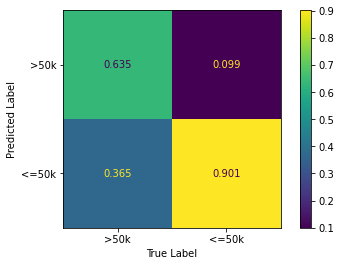

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0], normalize="pred" ),
                       display_labels=[">50k","<=50k"]).plot(values_format='.3f',ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
run.finish()